## 🎨 Generative Adversarial Networks (GANs)

## 🧰 Setting Up Our Tools: Installing and Importing Libraries


Before we can build and train our GAN, we need to set up our Python environment with the right tools.

- 🔧 **PyTorch** – a deep learning library we’ll use to build and train our neural networks.
- 🖼️ **Torchvision** – provides easy access to common datasets (like MNIST) and helper functions for images.
- 📊 **Matplotlib & NumPy** – used for visualizing data and handling numerical operations.

We’ll also import essential modules like:
- `nn` for defining our neural network layers,
- `optim` for optimization algorithms (like Adam),
- `transforms` for preprocessing image data,
- and `make_grid` for visualizing multiple images at once in a grid.


In [1]:
# 📦 Install key dependencies silently (if not already installed)
# - torch: main deep learning library
# - torchvision: utilities for image datasets and models
# - matplotlib: for plotting and visualizing images
!pip install -q torch torchvision matplotlib

# 🚀 Import essential PyTorch and utility libraries
import torch  # Core PyTorch tensor library
import torchvision  # Utilities and datasets for vision tasks
import torch.nn as nn  # Tools to define neural network layers
import torch.optim as optim  # Optimization algorithms like Adam and SGD

from torchvision import datasets, transforms  # Access to datasets and image transformations
from torchvision.utils import make_grid  # For displaying image batches in a grid

import matplotlib.pyplot as plt  # Plotting library
import numpy as np  # Numerical computation library

import os  # OS-level utilities (e.g., creating folders to save images)

## 🔁 Setup for Reproducibility and Device Configuration

To make sure we get consistent results every time we run the notebook, we’ll set a random seed. This ensures our model training and data shuffling are repeatable — an essential step when experimenting or debugging.

We’ll also check if we have access to a **GPU** (Graphics Processing Unit). If yes, we’ll use it to accelerate training. If not, we’ll default to using the CPU.



In [2]:
# 🎲 Reproducibility: Set a manual seed so results are consistent across runs
torch.manual_seed(42)

In [3]:
# ⚙️ Device configuration:
# Use GPU if available, otherwise fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu



## 🗂️ Loading and Visualizing the MNIST Dataset

Now let’s load the **MNIST dataset**, a classic collection of 60,000 grayscale images of handwritten digits (0–9), each sized **28×28 pixels**.

To prepare the images for our GAN:
- We convert them into **PyTorch tensors** using `ToTensor()`.
- We then **normalize** their pixel values from `[0, 1]` to `[-1, 1]` using `Normalize([0.5], [0.5])`. This is important because our Generator will later use a `Tanh()` activation, which also outputs in the `[-1, 1]` range.

Finally, we visualize a grid of images from one training batch so we can see what kind of data our GAN is trying to learn.


In [4]:

# Set batch size for DataLoader and visualization
batch_size = 64

# Track 2: New Dataset Challenge - Using FashionMNIST

from torchvision import datasets, transforms

# Define transformation same as MNIST but on FashionMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load FashionMNIST dataset (grayscale, 28x28 like MNIST)
train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

# Update DataLoader for new dataset
batch_size = 64  # You can tune this as well
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)



print(f"Loaded FashionMNIST dataset with {len(train_dataset)} samples.")


Loaded FashionMNIST dataset with 60000 samples.


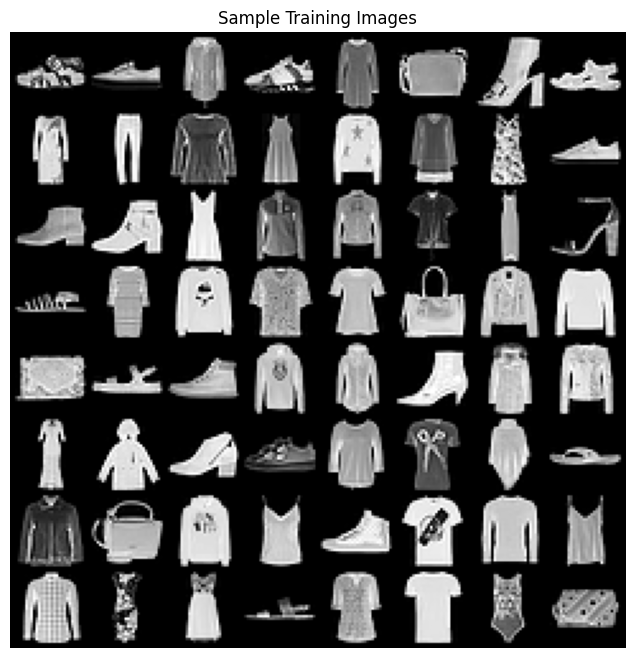

In [5]:

# 👁️ Visualize a batch of training images
images, _ = next(iter(train_loader))  # Ignore labels
num_preview = min(64, batch_size)     # Show up to 64 images or less if batch is smaller

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Sample Training Images")
plt.imshow(np.transpose(
    make_grid(images[:num_preview], padding=2, normalize=True).cpu(),
    (1, 2, 0)
))
plt.show()


# Now the Generator and Discriminator architectures stay the same
# Just restart training loop with these new images

"""## 🔍 What Are We Seeing?

This is a batch of 64 real images from the **MNIST** training dataset. Each image is a 28×28 grayscale digit.

- The images are arranged in an 8x8 grid.
- They've been normalized to the `[-1, 1]` range, which is why the background is black (−1) and the digits appear white (+1).
- This batch will serve as the **"real" data** during GAN training, and the Generator will try to learn how to produce similar-looking digits.

Later in training, we'll generate and compare fake samples side-by-side with real ones.

## 🧪 Sanity Check: Image Shape and Pixel Range

Before moving on, it's good practice to verify that our data has been loaded and preprocessed correctly:

- `images.shape` confirms the batch size and format. For MNIST, each image should have:
  - **1 channel** (grayscale)
  - **28×28** resolution

- Pixel values should now fall in the range **[-1, 1]** thanks to normalization. This is important because our Generator uses a `Tanh()` activation that outputs in the same range.
"""

In [6]:
# ✅ Sanity check: Let's verify the data shape and pixel value range

# Print the shape of the current batch
# Format: (batch_size, channels, height, width)
print(f"🧾 Batch shape: {images.shape}")

# Check pixel value range after normalization (should be ~[-1, 1])
min_val = images.min().item()
max_val = images.max().item()
print(f"🎚️ Pixel value range after normalization: min={min_val:.2f}, max={max_val:.2f}")



🧾 Batch shape: torch.Size([64, 1, 28, 28])
🎚️ Pixel value range after normalization: min=-1.00, max=1.00


## Here's what this means:

- `64`: The batch contains **64 images** — this matches the `batch_size` we set earlier.
- `1`: Each image has **1 channel**, which means it's a **grayscale** image.
- `28, 28`: The height and width of each image are **28 pixels**, as expected for MNIST.

✅ This confirms our DataLoader is working correctly and that the images are in the expected shape for training.

The pixel range from `-1.00 to 1.00` tells us that **normalization** worked:
- We applied `transforms.Normalize([0.5], [0.5])`, which shifts original `[0, 1]` pixel values into the range `[-1, 1]`.
- This is important because our Generator network will later use a `Tanh()` function to output images in the same range.

## ⚙️ Key Hyperparameters for GAN Training

Before building our Generator and Discriminator, let’s define the core hyperparameters:

- **`latent_dim = 100`**:  
  This defines the size of the random noise vector (also called the **latent space**).  
  The Generator will take this as input and try to convert it into a realistic image.  
  Think of it as the "creative inspiration" for the Generator.

- **`lr = 0.0002`**:  
  The learning rate used by both optimizers (Adam). This value is often chosen through experimentation — GANs can be very sensitive to it.

- **`image_size = 28`**:  
  We're generating 28x28 images to match the MNIST dataset.

- **`channels = 1`**:  
  Since MNIST images are grayscale, each image has 1 channel. If we were working with colored images like CIFAR-10, this would be 3.
"""

In [7]:
# 🎛️ Key Hyperparameters for Generator & Discriminator

latent_dim = 100     # Size of the noise vector (latent space) fed to the Generator.
                     # Higher values may allow more variation in generated images,
                     # but can also make training harder.

lr = 0.0002          # Learning rate for both Generator and Discriminator optimizers.
                     # Too high → unstable training. Too low → very slow convergence.

image_size = 28    # Target image size (MNIST is 28x28 pixels).

channels = 1         # Number of channels in the image (1 = grayscale, 3 = RGB).

## 🛠️ Building the Generator: Theory & Design Choices

The **Generator** is one half of our GAN system. Its job is to convert a random noise vector (also called a latent vector) into something that *looks like* a real MNIST digit.

---

### 🧠 What Is the Generator Actually Doing?

Think of the Generator as a function that maps **random noise → image**.

- It takes in a **latent vector** `z`, typically sampled from a standard normal distribution (values around 0).
- This vector exists in an abstract space called **latent space**.
- The Generator learns how to turn this noise into a structured 28×28 image that resembles a handwritten digit.

---

### 🧱 Architecture Breakdown: Why These Layers?

We use a simple **fully connected (linear)** architecture because MNIST digits are small and easy to model. Here's a breakdown of the layer design and reasoning:

1. **Input Layer**  
   - Input: `latent_dim = 100` (a 100-dimensional noise vector)  
   - Purpose: Provides a rich enough space for random variations  
   - Transformed to 128 neurons using a linear layer  
   - Activation: ReLU adds non-linearity so the network can model complex functions

2. **Hidden Layer 1**  
   - Expands from 128 → 256 neurons  
   - Adds **Batch Normalization** for more stable and faster training  
   - ReLU activation helps model complex relationships

3. **Hidden Layer 2**  
   - Further expands from 256 → 512 neurons  
   - More **Batch Normalization** for training stability  
   - ReLU activation continues the non-linearity chain

4. **Output Layer**  
   - Projects 512 → 784 neurons (28 × 28 pixels flattened)  
   - Activation: **Tanh** function, which outputs values in the range [-1, 1]  
   - This matches the range of our normalized MNIST images, making learning smoother

---

### 🖼️ Reshaping the Output

The output of the final layer is a flat 784-element vector. We reshape it into the format:

- Batch size × 1 × 28 × 28  
- Where 1 is the number of image channels (grayscale)

This produces an image the same size and shape as MNIST digits.

---

### 💡 Why Not Use Convolutional Layers?

While convolutional (ConvTranspose2d) layers are better suited for spatial data (like in DCGANs), we’re using a **Multi-Layer Perceptron (MLP)** for simplicity. For small images like MNIST:

- MLPs are easier to teach and understand
- They're faster to train
- They still produce decent results

This architecture is a great starting point before moving on to more advanced architectures.

---

### ✅ Summary

- The Generator turns random noise into fake digits  
- Each layer increases representational power  
- BatchNorm and ReLU help training converge smoothly  
- Tanh output matches the normalized MNIST pixel range  
- Simple fully connected layers work well for small grayscale images

Up next, we’ll test the Generator and visualize its output!



In [16]:

# 🧠 Define the Generator network
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        # 📐 Define the architecture using nn.Sequential:
        self.model = nn.Sequential(
            # 🧱 Layer 1: Project latent vector to 128-dimensional space
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),  # Non-linear activation (in-place)

            # 🧱 Layer 2: Expand to 256 neurons
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),  # Normalize output to stabilize training
            nn.ReLU(True),

            # 🧱 Layer 3: Expand further to 512 neurons
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),  # Normalize again
            nn.ReLU(True),

            # 🧱 Output Layer: 512 → 784 (flattened 28x28 image)
            nn.Linear(512, 784),
            nn.Tanh()  # Output pixel values in [-1, 1] to match normalized data
        )

    def forward(self, z):
        # 🚀 Pass the noise vector through the network
        img = self.model(z)

        # 🔄 Reshape the output to (batch_size, 1, 28, 28) — image format
        img = img.view(z.size(0), 1, 28, 28)

        return img  # Return a fake image

# 🧪 Instantiate the Generator and move it to GPU (if available)
generator = Generator(latent_dim).to(device)

# 📋 Print the architecture summary
print(generator)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=512, out_features=784, bias=True)
    (9): Tanh()
  )
)


## ✨ Generating Images from Random Noise

To produce a fake image, the Generator needs a **starting point** — a random vector from what we call **latent space**.

This latent space:
- Is a high-dimensional abstract space (here, 100 dimensions).
- Contains no meaningful features initially — just pure noise.
- But as the Generator trains, it learns how to map these noise vectors into realistic digit shapes.

In this step:

- We sample 16 random vectors from a **standard normal distribution** (𝒩(0, 1)).
- Each vector has length equal to our `latent_dim` (e.g. 100).
- We feed these vectors into the Generator to get **fake images**.
- Then we display the results in a 4x4 grid.

🧪 At this point in training, the Generator hasn’t learned anything — so the images still look like static noise. But after training, these same kinds of vectors will turn into digits.


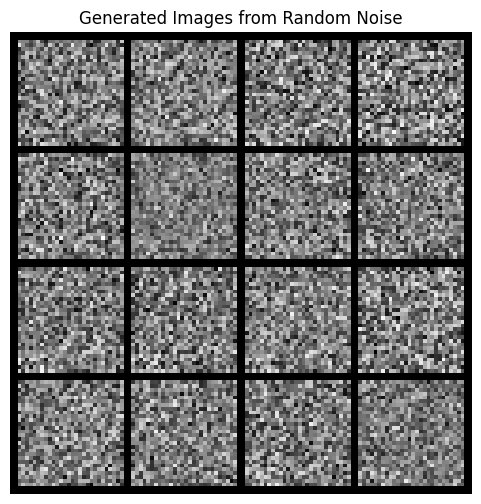

In [9]:
# 🎲 Generate random latent vectors (size: 16 x latent_dim)
z = torch.randn(16, latent_dim).to(device)

# 🧪 Pass the latent vectors through the Generator to get fake images
# Detach from graph and move to CPU for visualization
fake_images = generator(z).detach().cpu()

# 🖼️ Visualize the generated images in a 4x4 grid
plt.figure(figsize=(6, 6))
plt.axis("off")
plt.title("Generated Images from Random Noise")
plt.imshow(np.transpose(
    make_grid(fake_images, nrow= 4, padding=2, normalize=True),  # normalize for display
    (1, 2, 0)  # Rearrange from (C, H, W) → (H, W, C)
))
plt.show()

## 🛡️ Building the Discriminator: Theory & Architecture

The **Discriminator** is the second half of our GAN. While the Generator tries to *fool*, the Discriminator acts as a *detective* — its job is to distinguish between **real images** (from the dataset) and **fake images** (from the Generator).

---

### 🧠 What Does the Discriminator Actually Do?

The Discriminator is a **binary classifier**. For every image it receives, it outputs a **single probability value** between 0 and 1:

- **Output close to 1** → it believes the image is real
- **Output close to 0** → it believes the image is fake

---

### 🎯 Input Format

Each MNIST image is originally shaped as:
- 1 channel (grayscale)
- 28 pixels × 28 pixels

That gives us a total of **784 pixel values per image**. Before feeding images into the network, we **flatten** them from shape `(1, 28, 28)` to a **1D vector of length 784**.

---

### 🧱 Layer-by-Layer Architecture

We use a simple fully connected (MLP-style) network, as MNIST is low-dimensional and doesn’t require convolutional layers for this task.

#### **Input Layer**
- 784 → 512 neurons
- Activation: **LeakyReLU**
- Why? LeakyReLU avoids the "dying ReLU" problem by allowing a small gradient when the input is negative.

#### **Hidden Layer 1**
- 512 → 256 neurons
- Activation: **LeakyReLU**
- This deeper layer helps model complex relationships between pixels

#### **Output Layer**
- 256 → 1 neuron
- Activation: **Sigmoid**
- This produces a value between 0 and 1, interpreted as the **probability that the input is real**

---

### ⚙️ Flattening Logic in Forward Pass

In the `forward()` method, we reshape the input image like this:

- `img.view(img.size(0), -1)` turns each image into a flat vector of shape `(batch_size, 784)`
- This allows us to feed the image directly into `nn.Linear` layers

---

### 💡 Why Use LeakyReLU Instead of ReLU?

Standard ReLU activation sets all negative values to zero, which can cause **dead neurons** (i.e., weights that never update).

LeakyReLU allows a small, non-zero gradient when the input is negative (usually 0.01–0.2), which helps:
- Preserve gradient flow during training
- Prevent the network from getting stuck

---

### 🔄 How the Discriminator Learns

- During training, the Discriminator receives:
  - Real MNIST images (labeled as 1)
  - Fake images from the Generator (labeled as 0)
- It tries to correctly classify them
- Its loss improves when it’s **confident about what’s real and fake**
- Over time, it becomes harder for the Generator to fool it — this adversarial tension helps both models improve

---

### ✅ Summary

- The Discriminator is a **binary classifier** that outputs a probability of "realness"
- It flattens 28×28 images into 784-length vectors
- It uses **fully connected layers** with **LeakyReLU activations** and **Sigmoid output**
- It competes with the Generator to improve both networks through adversarial learning




In [10]:

# 🛡️ Define the Discriminator network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # 🧱 Architecture: fully connected layers to classify real vs fake
        self.model = nn.Sequential(
            # Input: Flattened image of 784 values (28x28)
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),  # Allows small negative gradients (0.2 slope)

            # Hidden layer: 512 → 256
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),

            # Output layer: 256 → 1
            # This outputs a single scalar value representing probability
            nn.Linear(256, 1),
            nn.Sigmoid()  # Squashes output into [0, 1] range (for binary classification)
        )

    def forward(self, img):
        # 🔄 Flatten the image from (batch_size, 1, 28, 28) → (batch_size, 784)
        img_flat = img.view(img.size(0), -1)

        # 🧠 Pass through the network to get real/fake probability
        validity = self.model(img_flat)

        return validity

# ⚙️ Instantiate the Discriminator and move to GPU (if available)
discriminator = Discriminator().to(device)

# 🖥️ Print the model summary
print(discriminator)


Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


## 🔁 Generator vs Discriminator in Code: Losses & Optimization

To train our GAN, we need to define two things:

---

### 🎯 Loss Function: `BCELoss` (Binary Cross-Entropy Loss)

We use **Binary Cross-Entropy Loss** because this is a **binary classification task**:

- The Discriminator must classify each image as:
  - 1 (real)
  - 0 (fake)
- The Generator tries to make the Discriminator **output 1** for its fake images.

This creates two opposing objectives:
- The **Discriminator** is trained to maximize its ability to distinguish real from fake.
- The **Generator** is trained to fool the Discriminator into thinking its output is real.

So we use the same loss function for both networks — but we apply it with **different labels**.

---

### ⚙️ Optimizers: Adam

We use the **Adam optimizer**, which adapts the learning rate during training and is known to work well for GANs.

We define separate optimizers for:
- `optimizer_G` — updates the Generator
- `optimizer_D` — updates the Discriminator

Each uses:
- The same learning rate (`lr`) defined earlier
- `betas=(0.5, 0.999)` — a common choice in GAN literature that stabilizes training

> 💡 Note: These values come from the original DCGAN paper and help reduce mode collapse and instability.



In [11]:
# 🎯 Binary Cross Entropy Loss for both Generator and Discriminator
# Measures how well the Discriminator can distinguish real vs fake
adversarial_loss = nn.BCELoss()

# ⚙️ Optimizer for Generator
# Learns how to map noise → realistic image
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

# ⚙️ Optimizer for Discriminator
# Learns how to classify image → real (1) or fake (0)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

## 🔄 Training the GAN: Step-by-Step Breakdown

Training a GAN is a balancing act between two networks:
- The **Discriminator (D)** learns to tell real from fake.
- The **Generator (G)** learns to produce fakes good enough to fool the Discriminator.

We alternate training both networks in a loop. Each iteration consists of two main steps:

---

### 🛡️ 1. Training the Discriminator

Goal: Make the Discriminator better at telling real images from fake ones.

For each batch:

- We pass **real images** from the dataset into the Discriminator and assign them **label 1.0**.
- We generate **fake images** using the Generator and assign them **label 0.0**.
- The Discriminator tries to output:
  - Close to 1 for real images
  - Close to 0 for fake images
- We compute the **total loss** as the sum of the real and fake losses.
- We call `d_loss.backward()` to compute gradients and `optimizer_D.step()` to update Discriminator weights.

---

### 🎭 2. Training the Generator

Goal: Make the Generator produce fakes that the Discriminator believes are real.

- We generate a new batch of fake images.
- We feed these fake images into the **Discriminator**, but this time we label them as **real (1.0)**.
- Why? Because we want the Generator to fool the Discriminator!
- The Generator loss is based on how well it *fakes* the label 1.0.
- We call `g_loss.backward()` and `optimizer_G.step()` to update Generator weights.

---

### 🧾 Other Key Elements in the Code

- `real_label = 1.` and `fake_label = 0.`: These are targets used in Binary Cross Entropy Loss.
- `detach()` prevents gradients from flowing into the Generator when training the Discriminator.
- We track both **G_losses** and **D_losses** over time for plotting.
- Every epoch, we generate 16 fake images and save them using `matplotlib` and `torchvision`.

---

### 💡 Why Do We Save Images Every Epoch?

By saving generated images per epoch:
- You can **visually track progress**
- See how noise evolves into actual digits
- Compare early vs. late training to diagnose problems (e.g., mode collapse)

The images are saved to the `"generated_images"` folder and labeled by epoch.

---

### 🕹️ Key Parameters

- `epochs = 30`: Number of passes through the full dataset.
- `batch_size`: Controls how many images we use in one iteration (set earlier).
- `latent_dim`: Size of the noise vector (set earlier).

---

### ✅ Summary

Each training step consists of:
1. Training D on real and fake images separately
2. Training G to fool D
3. Logging losses and saving outputs for analysis

This back-and-forth creates an adversarial process where both networks improve together.


In [12]:

# 📁 Create a directory to store generated images (if it doesn't exist already)
os.makedirs("generated_images", exist_ok=True)

# 🎯 Define label values
real_label = 1.0  # Real images will be labeled as 1
fake_label = 0.0  # Fake/generated images will be labeled as 0

# 📊 Initialize trackers for plotting loss curves later
G_losses = []  # Generator loss per iteration
D_losses = []  # Discriminator loss per iteration

# 🔁 Number of times we iterate over the entire dataset




epochs = 30





# 🔄 Start training loop
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(train_loader):

        # ====================
        # 1️⃣ Train Discriminator
        # ====================

        # 🧠 Step 1: Reset Discriminator gradients
        discriminator.zero_grad()

        # 📥 Step 2: Get real images and move to device
        real_imgs = imgs.to(device)
        b_size = real_imgs.size(0)  # Get current batch size (may be smaller in last batch)

        # 🏷️ Step 3: Create labels for real images (all 1s)
        labels = torch.full((b_size, 1), real_label, device=device)

        # ⚖️ Step 4: Forward pass real images through Discriminator
        output_real = discriminator(real_imgs)
        loss_real = adversarial_loss(output_real, labels)

        # 🎲 Step 5: Generate fake images from random noise
        z = torch.randn(b_size, latent_dim, device=device)
        fake_imgs = generator(z)

        # 🏷️ Step 6: Create labels for fake images (all 0s)
        labels_fake = torch.full((b_size, 1), fake_label, device=device)

        # ⚖️ Step 7: Forward pass fake images through Discriminator
        # Important: .detach() prevents gradients from flowing into the Generator
        output_fake = discriminator(fake_imgs.detach())
        loss_fake = adversarial_loss(output_fake, labels_fake)

        # 🧮 Step 8: Combine real + fake loss
        d_loss = loss_real + loss_fake

        # 🔁 Step 9: Backpropagation and update Discriminator weights
        d_loss.backward()
        optimizer_D.step()

        # ====================
        # 2️⃣ Train Generator
        # ====================

        # 🧠 Step 10: Reset Generator gradients
        generator.zero_grad()

        # 🏷️ Step 11: Use real labels for fake images to fool the Discriminator
        labels_gen = torch.full((b_size, 1), real_label, device=device)

        # ⚖️ Step 12: Forward fake images through Discriminator (no .detach())
        output = discriminator(fake_imgs)

        # 🎯 Step 13: Compute Generator loss (how well it fooled the Discriminator)
        g_loss = adversarial_loss(output, labels_gen)

        # 🔁 Step 14: Backpropagation and update Generator weights
        g_loss.backward()
        optimizer_G.step()

        # 📝 Step 15: Save loss values for visualization
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

    # 🖨️ Print progress after each epoch
    print(f"[{epoch+1}/{epochs}]  D loss: {d_loss.item():.4f} | G loss: {g_loss.item():.4f}")

    # ====================
    # 🖼️ Save Generated Samples from Current Epoch
    # ====================
    with torch.no_grad():
        z = torch.randn(16, latent_dim, device=device)
        fake_imgs = generator(z).detach().cpu()
        grid = make_grid(fake_imgs, normalize=True)

        # Plot and save as image file
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
        ax.axis("off")
        ax.set_title(f"Epoch {epoch+1}", fontsize=12, pad=10)

        fig.savefig(f"generated_images/epoch_{epoch+1:03d}.png")
        plt.close(fig)  # Free up memory

[1/30]  D loss: 1.1090 | G loss: 1.3743
[2/30]  D loss: 1.2948 | G loss: 0.7348
[3/30]  D loss: 1.1029 | G loss: 1.2384
[4/30]  D loss: 1.2126 | G loss: 1.1032
[5/30]  D loss: 1.2587 | G loss: 1.3481
[6/30]  D loss: 1.1578 | G loss: 1.1302
[7/30]  D loss: 1.2778 | G loss: 0.8958
[8/30]  D loss: 1.4655 | G loss: 0.8449
[9/30]  D loss: 1.3471 | G loss: 0.8676
[10/30]  D loss: 1.2702 | G loss: 1.1729
[11/30]  D loss: 1.3038 | G loss: 1.2194
[12/30]  D loss: 1.2111 | G loss: 0.9334
[13/30]  D loss: 1.2260 | G loss: 1.0543
[14/30]  D loss: 1.2782 | G loss: 0.8668
[15/30]  D loss: 1.2708 | G loss: 0.9432
[16/30]  D loss: 1.1892 | G loss: 1.1787
[17/30]  D loss: 1.2752 | G loss: 0.9109
[18/30]  D loss: 1.2444 | G loss: 1.1212
[19/30]  D loss: 1.3521 | G loss: 0.8842
[20/30]  D loss: 1.2765 | G loss: 0.9377
[21/30]  D loss: 1.2539 | G loss: 0.9422
[22/30]  D loss: 1.2763 | G loss: 0.9907
[23/30]  D loss: 1.1877 | G loss: 0.9576
[24/30]  D loss: 1.2547 | G loss: 0.9635
[25/30]  D loss: 1.2339 |

## 📉 Understanding Generator and Discriminator Loss Curves

After training the GAN, we plot the loss values of both the Generator and the Discriminator over time to monitor how well the model is learning.

---

### 🔵 Generator Loss (G)

- Measures how well the Generator is **fooling the Discriminator**.
- Starts off **high**, since the Generator is producing pure noise at the beginning.
- As training progresses, the Generator learns to produce more realistic images, and the loss typically **decreases** or **fluctuates around 1.0**.
- **Fluctuations are normal** due to the adversarial nature of GAN training.

---

### 🟠 Discriminator Loss (D)

- Measures how well the Discriminator can **distinguish real images from fake**.
- Initially, it might drop quickly as it's easy to spot random noise.
- Over time, as the Generator improves, the Discriminator's task gets harder, and its loss usually **rises toward 0.5–0.8**.
- If the Discriminator becomes too good (**loss near 0**), the Generator may struggle to learn.

---

### ⚠️ Interpreting the Loss Curves

- If **Discriminator loss is very low** and **Generator loss is very high** → The Discriminator is overpowering the Generator.
- If both losses are **completely flat** → Training may be stuck or the model has collapsed.
- If losses **oscillate** → That’s normal. GANs don’t converge like traditional models; they engage in a dynamic, adversarial learning process.

---

### 📌 Key Insight

Loss curves are a helpful signal — but not the full story.  
Always **inspect the generated images visually** to assess actual output quality. Good loss values don’t guarantee good images, and vice versa.


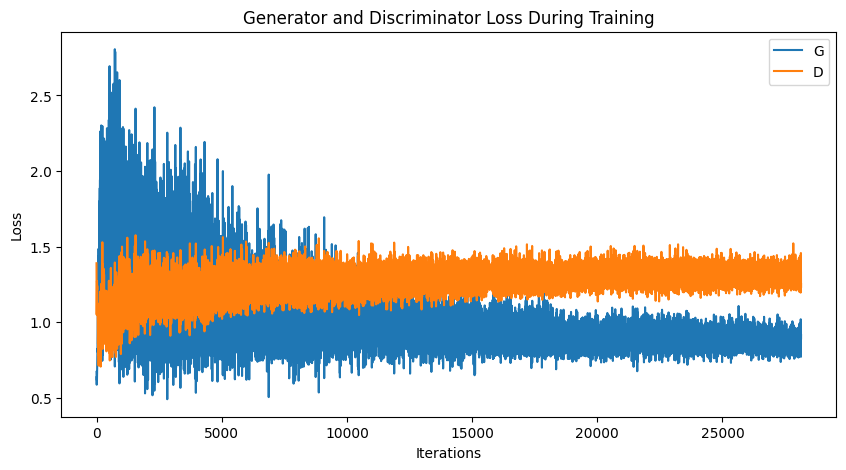

In [13]:

# 📊 Create a figure for the loss plot
plt.figure(figsize=(10, 5))  # Set width and height of the plot in inches

# 🏷️ Title for the entire plot
plt.title("Generator and Discriminator Loss During Training")

# 📈 Plot Generator loss values over training iterations
plt.plot(G_losses, label="G")  # G_losses was recorded in the training loop

# 📉 Plot Discriminator loss values
plt.plot(D_losses, label="D")  # D_losses was also tracked per iteration

# 🧭 Label x-axis as "Iterations" (each step = 1 batch)
plt.xlabel("Iterations")

# 🧭 Label y-axis as "Loss"
plt.ylabel("Loss")

# 🏷️ Show legend to distinguish between Generator and Discriminator
plt.legend()

# 📤 Display the plot
plt.show()

### 🖼️ Visualizing Generated Samples Over Epochs

To better understand how the Generator improves during training, we create an **animated GIF** composed of sample outputs at the end of each epoch.

---

#### 📦 What This Section Does:

- **Loads** all saved `.png` images from the `generated_images/` directory. These images were saved at the end of each training epoch.
- **Sorts** them by filename to ensure chronological order (e.g., `epoch_001.png`, `epoch_002.png`, ...).
- **Opens** each image using the PIL library and stores them in a list of frames.
- **Saves** the sequence of frames as a `.gif` file called `gan_training_progress.gif`, where each frame represents one epoch's output.
- **Displays** the final animated GIF inline in the notebook using IPython.

---

#### 🎯 Why This Matters:

Visualizing the outputs across epochs is a powerful way to:
- Evaluate whether the Generator is learning meaningful representations.
- Detect **issues** like mode collapse (where all images look the same) or failure to converge (random noise).
- Observe **progressive refinement** of image details, structure, and clarity over time.
- Complement numerical loss metrics (which are often unstable or misleading in GANs).

---

#### ⚙️ Technical Notes:

- The frame delay is set to `400 ms` per image.
- `loop=0` means the animation will repeat forever.
- The final `.gif` file provides an easily shareable visual summary of training.

This visualization technique is widely used in GAN research and development for tracking qualitative improvements.



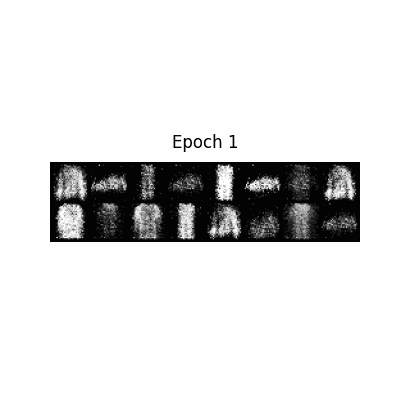

Conditional GAN models ready. Remember to pass labels during training.
DCGAN models ready with convolutional layers!


In [14]:
# Import necessary libraries
import glob                                  # To retrieve file paths matching a pattern
from PIL import Image                        # For opening and manipulating image files
from IPython.display import Image as IPyImage, display  # To display images in Jupyter notebooks

# Initialize an empty list to hold all the frames
frames = []

# Retrieve all image paths that match the saved epoch pattern and sort them in order
image_paths = sorted(glob.glob("generated_images/epoch_*.png"))

# Load each image and append it to the list of frames
for path in image_paths:
    frame = Image.open(path)
    frames.append(frame)

# Save the frames as an animated GIF
frames[0].save(
    "gan_training_progress.gif",    # Output filename
    format='GIF',                   # File format
    append_images=frames[1:],       # Remaining frames after the first one
    save_all=True,                  # Save all frames (not just first)
    duration=400,                   # Delay per frame in milliseconds
    loop=0                          # Loop infinitely
)

# Display the saved GIF in the notebook
display(IPyImage(filename="gan_training_progress.gif"))

# Track 3: Conditional GAN (cGAN) setup

import torch.nn.functional as F

class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim, num_classes=10, embedding_dim=50):
        super(ConditionalGenerator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, embedding_dim)
        self.model = nn.Sequential(
            nn.Linear(latent_dim + embedding_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embedding = self.label_emb(labels)
        gen_input = torch.cat((noise, label_embedding), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), 1, 28, 28)
        return img

class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes=10, embedding_dim=50):
        super(ConditionalDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, embedding_dim)
        self.model = nn.Sequential(
            nn.Linear(784 + embedding_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        img_flat = img.view(img.size(0), -1)
        label_embedding = self.label_emb(labels)
        d_in = torch.cat((img_flat, label_embedding), -1)
        validity = self.model(d_in)
        return validity

# Instantiate conditional GAN models
latent_dim = 100
generator = ConditionalGenerator(latent_dim).to(device)
discriminator = ConditionalDiscriminator().to(device)

# Define optimizers and loss function as before
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
adversarial_loss = nn.BCELoss()

print("Conditional GAN models ready. Remember to pass labels during training.")

# Track 4: DCGAN — Define Convolutional Generator and Discriminator

class DCGenerator(nn.Module):
    def __init__(self, latent_dim, channels=1):
        super(DCGenerator, self).__init__()
        self.init_size = 7  # Output of first layer will be (channels, 7, 7)
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),  # Upsample to 14x14
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2),  # Upsample to 28x28
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

class DCDiscriminator(nn.Module):
    def __init__(self, channels=1):
        super(DCDiscriminator, self).__init__()
        def discriminator_block(in_filters, out_filters, bn=True):
            layers = [nn.Conv2d(in_filters, out_filters, 3, 2, 1),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Dropout2d(0.25)]
            if bn:
                layers.append(nn.BatchNorm2d(out_filters, 0.8))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128 * 2 * 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.size(0), -1)
        validity = self.adv_layer(out)
        return validity

latent_dim = 100
channels = 1  # Grayscale images

generator = DCGenerator(latent_dim, channels).to(device)
discriminator = DCDiscriminator(channels).to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
adversarial_loss = nn.BCELoss()
print("DCGAN models ready with convolutional layers!")


## 🎮 Mini Game: Become the Discriminator!
### The Visual Turing Test 🤖👀

Welcome to your first challenge! You've trained the Generator to try and fool a neural network...  
Now **you** become the Discriminator! 🤖👀

Your task is simple:
- You’ll be shown one image at a time.
- It was either **generated by your GAN** (fake) or taken **from the real MNIST dataset** (real).
- Your job is to **guess**: `Real 👍` or `Fake 🤖`.

### 🔥 Challenge:
Try to reach a **win streak of 10 correct guesses in a row**.  
If you guess wrong, your streak resets to zero. No pressure. 😉

This exercise will help you:
- Develop an intuitive feel for how good your Generator is.
- Understand the difficulty of distinguishing between real and fake data.
- Appreciate the challenge the Discriminator faces during training.

> Let's see if you can outsmart your own neural network! 💡

"""

In [15]:
import torch
import random
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from torchvision.utils import make_grid

# Output widget to display everything
output_box = widgets.Output()

# Global state
image_tensor, answer = None, None
win_streak = 0  # Initialize win streak

# Function to generate either a real or fake image
def real_or_fake_game():
    if random.random() < 0.5:
        img, _ = next(iter(train_loader))  # Real image
        return img[0], "real"
    else:
        z = torch.randn(1, latent_dim).to(device)
        generator.eval()
        with torch.no_grad():
            img = generator(z).cpu()
        generator.train()
        return img[0], "fake"

# Game logic function
def make_guess(guess):
    global image_tensor, answer, win_streak
    with output_box:
        clear_output(wait=True)
        # Show win streak
        print(f"🔥 Win Streak: {win_streak}")

        # Display image
        plt.imshow(image_tensor.squeeze().numpy(), cmap="gray")
        plt.axis("off")
        plt.show()

        # Handle guess
        if guess == answer:
            win_streak += 1
        else:
            win_streak = 0  # Reset streak

        # Load new image for next round
        image_tensor, answer = real_or_fake_game()

# Buttons
real_button = widgets.Button(description="Real 👍", button_style='success')
fake_button = widgets.Button(description="Fake 🤖", button_style='danger')
real_button.on_click(lambda b: make_guess("real"))
fake_button.on_click(lambda b: make_guess("fake"))

# Initialize first image
image_tensor, answer = real_or_fake_game()

# Display interface
display(widgets.VBox([output_box, widgets.HBox([real_button, fake_button])]))

# Show first image without guessing
with output_box:
    clear_output(wait=True)
    print(f"🔥 Win Streak: {win_streak}")
    plt.imshow(image_tensor.squeeze().numpy(), cmap="gray")
    plt.axis("off")
    plt.show()

## 🚀 Take Your GAN Knowledge Further: 4 Learning Tracks

You've just built and trained your first Generative Adversarial Network (GAN) — great work!  
Now it's time to level up. Below are 4 exciting tracks that will help you grow from GAN beginner to advanced practitioner.  
You can explore these tracks in **any order**, but we recommend starting with Track 1 or 2 for smooth progression.

---

### 🧪 **Track 1: Hyperparameter Hacking**

🔧 *"Can you fine-tune your GAN like a pro?"*

- Try changing:
  - `latent_dim` (e.g. 50, 100, 200): affects the diversity of outputs
  - Learning rate (`lr`): use different rates for generator vs discriminator
  - Batch size: impacts training stability
  - Epoch count: more training isn't always better!
- Plot the loss curves and visualize generated samples over time.

💡 **Hint:**
Start by changing **one hyperparameter at a time** so you can clearly observe its effect.

🎯 **Goal:** Understand how each parameter influences training dynamics and output quality.

---

### 🖼️ **Track 2: New Dataset Challenge**

📦 *"Train your GAN on a new kind of data!"*

- Replace the MNIST dataset with:
  - `FashionMNIST` – grayscale clothing images
  - `CIFAR-10` – small RGB object images
  - `CelebA` – celebrity faces (advanced, requires image resizing)
- You may need to modify:
  - The number of channels (1 → 3 for color)
  - The architecture (especially with higher-res images)

💡 **Hint:**
Use `transforms.Resize()` and `transforms.Normalize()` appropriately for new image shapes and scales.

🎯 **Goal:** Learn how GANs adapt (or fail) when the dataset changes in complexity and structure.

---

### 🎯 **Track 3: Conditional GAN (cGAN)**

🧠 *"Tell your GAN what to generate."*

- Add **label information** to:
  - The Generator (so it knows which class to draw)
  - The Discriminator (so it learns to detect class-conditioned realism)
- Train on MNIST to generate specific digits (e.g., all 5s or 9s).
- Use label embeddings or concatenate noise + labels.

💡 **Hint:**
Start with conditional MNIST — it’s small and well-structured. Check out `nn.Embedding` in PyTorch to convert labels to vectors.

🎯 **Goal:** Learn how to steer the output of a GAN by conditioning it on input labels.

---

### 🧱 **Track 4: Deep Convolutional GAN (DCGAN)**

🖼 *"Upgrade your architecture — go convolutional."*

- Replace `nn.Linear` layers with:
  - `nn.ConvTranspose2d` in the Generator
  - `nn.Conv2d` in the Discriminator
- Manage image shapes with care: `[batch_size, channels, height, width]`
- Better suited for higher-resolution or color datasets (e.g. CIFAR-10)

💡 **Hint:**
Look up the **DCGAN paper** or start with a working example on CIFAR-10. You’ll get to see colorful, realistic results!

🎯 **Goal:** Learn how convolution improves image realism and scale your GANs to more complex data.

---

🔥 *Bonus Tip:* Keep a logbook or notebook of what you try and observe. GANs are finicky — learning to debug and reflect is part of becoming a real GAN researcher.

Happy experimenting!

"""